In [1]:
import os
import sys

from pathlib import Path
from datetime import timedelta

import dateutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch

from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import trange
from TaPR_pkg import etapr

In [2]:
WINDOW_GIVEN = 49
WINDOW_SIZE = 50

EPOCH = 200

N_HIDDENS = 78
N_LAYERS = 4
BATCH_SIZE = 4096

STRIDE = 3

THRESHOLD = 0.56

os.environ['CUDA_VISIBLE_DEVICES'] = '2'

In [3]:
TRAIN_DATASET = sorted([x for x in Path("dataset/train/").glob("*.csv")])
TEST_DATASET = sorted([x for x in Path("dataset/test/").glob("*.csv")])
VALIDATION_DATASET = sorted([x for x in Path("dataset/validation/").glob("*.csv")])

In [4]:
def dataframe_from_csv(target):
    return pd.read_csv(target).rename(columns=lambda x: x.strip())

def dataframe_from_csvs(targets):
    return pd.concat([dataframe_from_csv(x) for x in targets])

In [5]:
TRAIN_DF_RAW = dataframe_from_csvs(TRAIN_DATASET)

In [6]:
TIMESTAMP_FIELD = "timestamp"
IDSTAMP_FIELD = 'id'
ATTACK_FIELD = "attack"
VALID_COLUMNS_IN_TRAIN_DATASET = TRAIN_DF_RAW.columns.drop([TIMESTAMP_FIELD, 'C02', 'C09', 'C10', 'C17', 'C18', 'C19', 'C22', 'C26', 'C29', 'C34', 'C36', 'C38', 'C39', 'C49', 'C52', 'C55', 'C61', 'C63', 'C64', 'C67', 'C69', 'C82', 'C85'])
VALID_COLUMNS_IN_TRAIN_DATASET

Index(['C01', 'C03', 'C04', 'C05', 'C06', 'C07', 'C08', 'C11', 'C12', 'C13',
       'C14', 'C15', 'C16', 'C20', 'C21', 'C23', 'C24', 'C25', 'C27', 'C28',
       'C30', 'C31', 'C32', 'C33', 'C35', 'C37', 'C40', 'C41', 'C42', 'C43',
       'C44', 'C45', 'C46', 'C47', 'C48', 'C50', 'C51', 'C53', 'C54', 'C56',
       'C57', 'C58', 'C59', 'C60', 'C62', 'C65', 'C66', 'C68', 'C70', 'C71',
       'C72', 'C73', 'C74', 'C75', 'C76', 'C77', 'C78', 'C79', 'C80', 'C81',
       'C83', 'C84', 'C86'],
      dtype='object')

In [7]:
TAG_MIN = TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].min()
TAG_MAX = TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].max()
TAG_MEAN = TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].mean()
TAG_STD = TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].std()

In [8]:
def normalize(df):
    ndf = df.copy()
    for c in df.columns:
        if TAG_MIN[c] == TAG_MAX[c]:
            ndf[c] = df[c] - TAG_MIN[c]
        else:
            ndf[c] = (df[c] - TAG_MIN[c]) / (TAG_MAX[c] - TAG_MIN[c])
    return ndf

def zscore(df):
    ndf = df.copy()
    for c in df.columns:
        if TAG_STD[c] == 0:
            ndf[c] = df[c] - TAG_MEAN[c]
        else:
            ndf[c] = (df[c] - TAG_MEAN[c]) / TAG_STD[c]
    return ndf

In [9]:
# TRAIN_DF = normalize(TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET]).ewm(alpha=0.9).mean()
TRAIN_DF = zscore(TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET]).ewm(alpha=0.9).mean()
TRAIN_DF

,C01,C03,C04,C05,C06,C07,C08,C11,C12,C13,...,C75,C76,C77,C78,C79,C80,C81,C83,C84,C86
0,-0.195926,0.130952,-0.510446,-1.286610,-0.232211,0.300756,-0.900937,-0.705245,0.788264,0.339643,...,-1.797287,-0.398040,-2.059612,-1.307732,0.840236,-1.208580,-1.482520,0.120975,-0.005607,1.405178
1,-0.403835,0.130952,0.291271,-1.274333,-0.516235,0.300756,-0.900937,-0.674580,0.790907,-0.659897,...,-1.797287,-0.383606,-2.059612,-1.306536,0.840236,-1.252031,-1.485776,0.120975,-0.005607,1.398200
2,-0.742052,0.130952,-0.348808,-1.231228,-0.469486,0.300756,-0.900937,-0.649292,0.791146,-0.108109,...,-1.795847,-0.399972,-2.098338,-1.304174,0.840236,-1.310443,-1.431503,0.120975,-0.005607,1.395975
3,-0.123514,0.130952,0.534879,-1.195489,-0.294992,0.300756,-0.900937,-0.625981,0.791169,-0.041992,...,-1.797143,-0.380681,-2.125367,-1.300028,0.840236,-1.347819,-1.401692,0.120975,-0.005607,1.414356
4,-0.769093,0.130952,0.305677,-1.188090,-0.277560,0.300756,-0.900937,-0.596266,0.791171,-0.035386,...,-1.797272,-0.359600,-2.112572,-1.299850,0.840236,-1.366340,-1.401130,0.120975,-0.005607,1.404501
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259195,0.088121,0.131004,0.199914,0.853775,0.169812,-0.286211,-0.900937,-1.452286,-0.793319,-0.183159,...,0.789496,-0.679931,0.762588,0.409312,1.685271,0.733961,0.064095,-0.600706,-0.005607,-0.586255
259196,-0.118703,0.130957,-0.121930,0.853775,0.116677,-0.286211,-0.900937,-1.456110,-0.793272,-0.028449,...,0.789496,-0.687148,0.718377,0.403100,1.685271,0.732037,0.067946,-0.600706,-0.005607,-0.609791
259197,-0.249835,0.130952,0.836642,0.853775,0.103398,-0.286211,-0.900937,-1.458827,-0.793267,-0.344103,...,0.789496,-0.700474,0.721653,0.400465,1.685271,0.732099,0.034496,-0.600706,-0.005607,-0.611614
259198,-0.238043,0.130952,0.417962,0.853443,0.181825,-0.286211,-0.900937,-1.458462,-0.793267,0.116234,...,0.789496,-0.731674,0.721980,0.398897,1.685271,0.732698,0.029541,-0.600706,-0.005607,-0.620298


In [10]:
def boundary_check(df):
    x = np.array(df, dtype=np.float32)
    return np.any(x > 1.0), np.any(x < 0), np.any(np.isnan(x))

In [11]:
boundary_check(TRAIN_DF)

(True, True, False)

In [12]:
class HaiDataset(Dataset):
    def __init__(self, timestamps, df, stride=1, attacks=None):
        self.ts = np.array(timestamps)
        self.tag_values = np.array(df, dtype=np.float32)
        self.valid_idxs = []
        for L in trange(len(self.ts) - WINDOW_SIZE + 1):
            R = L + WINDOW_SIZE - 1
            if dateutil.parser.parse(self.ts[R]) - dateutil.parser.parse(
                self.ts[L]
            ) == timedelta(seconds=WINDOW_SIZE - 1):
                self.valid_idxs.append(L)
        self.valid_idxs = np.array(self.valid_idxs, dtype=np.int32)[::stride]
        self.n_idxs = len(self.valid_idxs)
        print(f"# of valid windows: {self.n_idxs}")
        if attacks is not None:
            self.attacks = np.array(attacks, dtype=np.float32)
            self.with_attack = True
        else:
            self.with_attack = False

    def __len__(self):
        return self.n_idxs

    def __getitem__(self, idx):
        i = self.valid_idxs[idx]
        last = i + WINDOW_SIZE - 1
        item = {"attack": self.attacks[last]} if self.with_attack else {}
        item["ts"] = self.ts[i + WINDOW_SIZE - 1]
        item["given"] = torch.from_numpy(self.tag_values[i : i + WINDOW_GIVEN])
        item["answer"] = torch.from_numpy(self.tag_values[last])
        return item

In [13]:
HAI_DATASET_TRAIN = HaiDataset(TRAIN_DF_RAW[TIMESTAMP_FIELD], TRAIN_DF, stride=STRIDE)
HAI_DATASET_TRAIN[0]


# of valid windows: 334703


{'ts': '2021-07-11 10:00:49',
 'given': tensor([[-0.1959,  0.1310, -0.5104,  ...,  0.1210, -0.0056,  1.4052],
         [-0.4038,  0.1310,  0.2913,  ...,  0.1210, -0.0056,  1.3982],
         [-0.7421,  0.1310, -0.3488,  ...,  0.1210, -0.0056,  1.3960],
         ...,
         [-0.7568,  0.1310, -0.0580,  ...,  0.1210, -0.0056,  1.2720],
         [-0.5287,  0.1310,  0.0877,  ...,  0.1210, -0.0056,  1.2462],
         [-0.1717,  0.1310, -0.0948,  ...,  0.1210, -0.0056,  1.2176]]),
 'answer': tensor([-0.1360,  0.1829, -0.1514, -1.2472, -0.3748,  0.3008, -0.9009,  0.4663,
          2.3715, -0.2081, -0.3899, -1.3145, -1.2271, -0.5315, -0.4402, -0.4314,
          0.5649,  2.1518, -0.3374, -0.6695,  0.7815,  0.0888,  0.7283, -1.0395,
          1.6001, -1.0989, -1.3862, -1.4137,  0.0843,  2.3815,  0.0365,  0.3673,
          0.9009,  0.6696,  0.2951,  1.7891,  0.8239, -1.1188, -0.2240,  0.1150,
          0.9246, -0.4097, -0.3481, -1.6895,  0.8490, -1.1128, -0.8210, -3.3461,
          0.7937, -0.54

In [14]:
class StackedGRU(torch.nn.Module):
    def __init__(self, n_tags):
        super().__init__()
        self.rnn = torch.nn.GRU(
            input_size=n_tags,
            hidden_size=N_HIDDENS,
            num_layers=N_LAYERS,
            bidirectional=True,
            dropout=0,
        )
        self.fc = torch.nn.Linear(N_HIDDENS * 2, n_tags)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = x.transpose(0, 1)  # (batch, seq, params) -> (seq, batch, params)
        self.rnn.flatten_parameters()
        outs, _ = self.rnn(x)
        outs = self.relu(outs)
        out = self.fc(outs[-1])
        out = self.relu(out)
        
        return x[0] + out

In [15]:
MODEL = StackedGRU(n_tags=TRAIN_DF.shape[1])
MODEL.cuda()

StackedGRU(
  (rnn): GRU(63, 78, num_layers=4, bidirectional=True)
  (fc): Linear(in_features=156, out_features=63, bias=True)
  (relu): ReLU()
)

In [16]:
def train(dataset, model, batch_size, n_epochs):
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    optimizer = torch.optim.AdamW(model.parameters())
    loss_fn = torch.nn.MSELoss()
    epochs = trange(n_epochs, desc="training")
    best = {"loss": sys.float_info.max}
    loss_history = []
    for e in epochs:
        epoch_loss = 0
        for batch in dataloader:
            optimizer.zero_grad()
            given = batch["given"].cuda()
            guess = model(given)
            answer = batch["answer"].cuda()
            loss = loss_fn(answer, guess)
            loss.backward()
            epoch_loss += loss.item()
            optimizer.step()
        loss_history.append(epoch_loss)
        epochs.set_postfix_str(f"loss: {epoch_loss:.6f}")
        if epoch_loss < best["loss"]:
            best["state"] = model.state_dict()
            best["loss"] = epoch_loss
            best["epoch"] = e + 1
    return best, loss_history

In [17]:
%%time
MODEL.train()
BEST_MODEL, LOSS_HISTORY = train(HAI_DATASET_TRAIN, MODEL, BATCH_SIZE, EPOCH)


CPU times: user 1h 2min 26s, sys: 5min 59s, total: 1h 8min 25s
Wall time: 1h 7min 15s


In [18]:
BEST_MODEL["loss"], BEST_MODEL["epoch"]

(24.854316741228104, 199)

In [19]:
with open("model.pt", "wb") as f:
    torch.save(
        {
            "state": BEST_MODEL["state"],
            "best_epoch": BEST_MODEL["epoch"],
            "loss_history": LOSS_HISTORY,
        },
        f,
    )

In [20]:
with open("model.pt", "rb") as f:
    SAVED_MODEL = torch.load(f)

MODEL.load_state_dict(SAVED_MODEL["state"])

<All keys matched successfully>

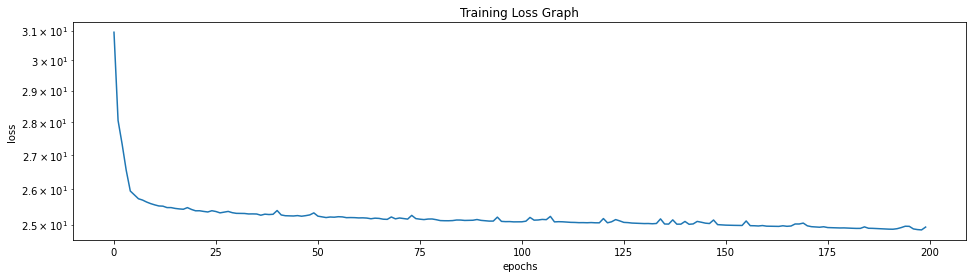

In [21]:
plt.figure(figsize=(16, 4))
plt.title("Training Loss Graph")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.yscale("log")
plt.plot(SAVED_MODEL["loss_history"])
plt.show()

In [22]:
VALIDATION_DF_RAW = dataframe_from_csvs(VALIDATION_DATASET)
VALIDATION_DF_RAW

,timestamp,C01,C02,C03,C04,C05,C06,C07,C08,C09,...,C78,C79,C80,C81,C82,C83,C84,C85,C86,attack
0,2021-07-10 00:00:01,-2.0395,0,11.78894,0.00058,16.32080,0.4010,12.903438,70,1,...,31.52100,0.716042,386.51172,356.64423,1,1034.712769,12.0,50,161,0
1,2021-07-10 00:00:02,-2.1750,0,11.78894,-0.00282,15.95459,0.4187,12.903438,70,1,...,31.51756,0.716042,411.33905,352.08698,1,1034.712769,12.0,50,155,0
2,2021-07-10 00:00:03,-2.5854,0,11.78131,-0.00398,14.79492,0.0691,12.903438,70,1,...,31.50269,0.716042,438.15259,347.63818,1,1034.712769,12.0,50,149,0
3,2021-07-10 00:00:04,-2.4722,0,11.78894,-0.00152,14.72626,0.3306,12.903438,70,1,...,31.47942,0.716042,465.95908,340.33203,1,1034.712769,12.0,50,148,0
4,2021-07-10 00:00:05,-2.2319,0,11.78131,0.00072,14.78729,0.2150,12.903438,70,1,...,31.47942,0.716042,452.05582,335.17798,1,1034.712769,12.0,50,148,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86395,2021-07-10 23:59:56,-2.8150,0,12.26196,0.00130,15.53497,-0.0507,12.669310,70,1,...,31.79814,0.716042,1193.48230,347.58386,1,1018.394040,12.0,50,7,0
86396,2021-07-10 23:59:57,-2.6272,0,12.26196,0.00109,15.53497,0.1829,12.669310,70,1,...,31.79738,0.716042,1179.76929,348.03607,1,1018.394040,12.0,50,7,0
86397,2021-07-10 23:59:58,-2.3564,0,12.26196,-0.00101,15.53497,0.2907,12.669310,70,1,...,31.78784,0.716042,1152.66187,348.81366,1,1018.394040,12.0,50,7,0
86398,2021-07-10 23:59:59,-2.1541,0,12.26196,-0.00166,15.53497,0.3280,12.669310,70,1,...,31.77029,0.716042,1130.65723,349.13916,1,1018.394040,12.0,50,7,0


In [23]:
# VALIDATION_DF = normalize(VALIDATION_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET])
VALIDATION_DF = zscore(VALIDATION_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET])

In [24]:
HAI_DATASET_VALIDATION = HaiDataset(
    VALIDATION_DF_RAW[TIMESTAMP_FIELD], VALIDATION_DF, attacks=VALIDATION_DF_RAW[ATTACK_FIELD]
)
HAI_DATASET_VALIDATION[0]


# of valid windows: 86351


{'attack': 0.0,
 'ts': '2021-07-10 00:00:50',
 'given': tensor([[ 0.0294, -3.4469,  0.3714,  ...,  0.6213, -0.0056, -0.5699],
         [-0.1065, -3.4469, -1.6964,  ...,  0.6213, -0.0056, -0.5734],
         [-0.5180, -3.5046, -2.4019,  ...,  0.6213, -0.0056, -0.5770],
         ...,
         [-0.8407, -3.4469,  0.2802,  ...,  0.6213, -0.0056,  2.4745],
         [ 0.0274, -3.4469, -1.2585,  ...,  0.6213, -0.0056,  2.4692],
         [-0.7916, -3.4469, -0.1577,  ...,  0.6213, -0.0056,  2.4763]]),
 'answer': tensor([-0.1079, -3.4469,  0.0187, -1.1986, -0.0286,  1.3132, -0.9009, -1.0536,
         -0.7497,  0.3460, -0.2262, -0.4389, -1.9186,  1.5558, -0.2141, -1.1741,
         -0.8260,  0.8419, -1.1313, -1.5681,  0.8815,  0.5617, -1.5575, -0.6922,
          1.9196, -0.8168, -1.3621, -1.4716, -0.0205, -0.3570, -0.2614,  1.3662,
          0.9009,  0.3641,  0.2951,  1.5107,  1.7929, -1.0801,  0.3242, -0.6203,
         -0.5707,  0.5061,  0.4730, -0.4140,  1.0348, -1.0752, -1.4730, -1.1408,
       

In [25]:
def inference(dataset, model, batch_size):
    dataloader = DataLoader(dataset, batch_size=batch_size)
    ts, dist, att = [], [], []
    with torch.no_grad():
        for batch in dataloader:
            given = batch["given"].cuda()
            answer = batch["answer"].cuda()
            guess = model(given)
            ts.append(np.array(batch["ts"]))
            dist.append(torch.abs(answer - guess).cpu().numpy())
            try:
                att.append(np.array(batch["attack"]))
            except:
                att.append(np.zeros(batch_size))
            
    return (
        np.concatenate(ts),
        np.concatenate(dist),
        np.concatenate(att),
    )

In [26]:
%%time
MODEL.eval()
CHECK_TS, CHECK_DIST, CHECK_ATT = inference(HAI_DATASET_VALIDATION, MODEL, BATCH_SIZE)

CPU times: user 2.42 s, sys: 457 ms, total: 2.87 s
Wall time: 2.87 s


In [27]:
ANOMALY_SCORE = np.mean(CHECK_DIST, axis=1)

In [28]:
def check_graph(xs, att, piece=2, THRESHOLD=None):
    l = xs.shape[0]
    chunk = l // piece
    fig, axs = plt.subplots(piece, figsize=(20, 4 * piece))
    for i in range(piece):
        L = i * chunk
        R = min(L + chunk, l)
        xticks = range(L, R)
        axs[i].plot(xticks, xs[L:R])
        if len(xs[L:R]) > 0:
            peak = max(xs[L:R])
            axs[i].plot(xticks, att[L:R] * peak * 0.3)
        if THRESHOLD!=None:
            axs[i].axhline(y=THRESHOLD, color='r')
    plt.show()

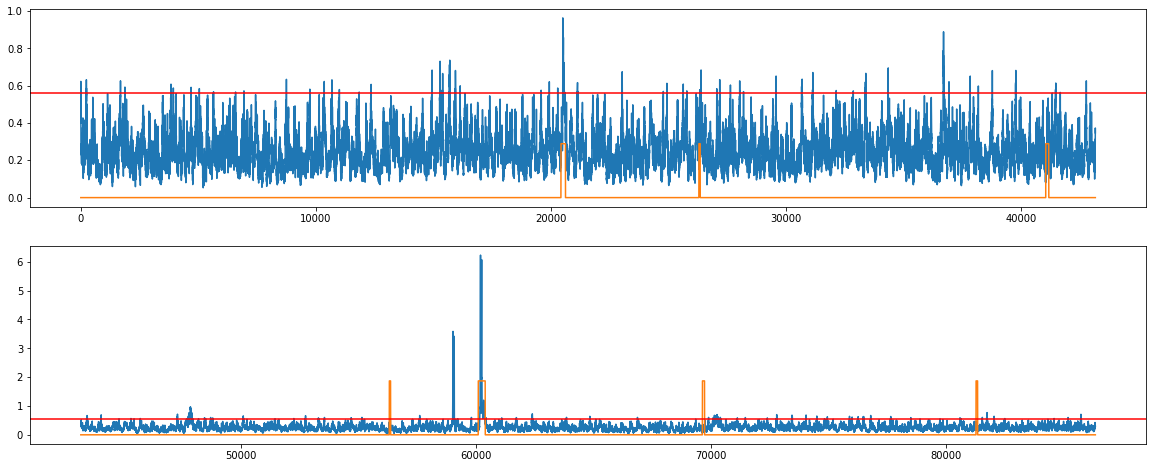

In [29]:
check_graph(ANOMALY_SCORE, CHECK_ATT, piece=2, THRESHOLD=THRESHOLD)

In [30]:
def put_labels(distance, threshold):
    xs = np.zeros_like(distance)
    xs[distance > threshold] = 1
    return xs

In [31]:
LABELS = put_labels(ANOMALY_SCORE, THRESHOLD)
LABELS, LABELS.shape

(array([0., 1., 0., ..., 0., 0., 0.], dtype=float32), (86351,))

In [32]:
ATTACK_LABELS = put_labels(np.array(VALIDATION_DF_RAW[ATTACK_FIELD]), threshold=0.5)
ATTACK_LABELS, ATTACK_LABELS.shape

(array([0, 0, 0, ..., 0, 0, 0]), (86400,))

In [33]:
def fill_blank(check_ts, labels, total_ts):
    def ts_generator():
        for t in total_ts:
            yield dateutil.parser.parse(t)

    def label_generator():
        for t, label in zip(check_ts, labels):
            yield dateutil.parser.parse(t), label

    g_ts = ts_generator()
    g_label = label_generator()
    final_labels = []

    try:
        current = next(g_ts)
        ts_label, label = next(g_label)
        while True:
            if current > ts_label:
                ts_label, label = next(g_label)
                continue
            elif current < ts_label:
                final_labels.append(0)
                current = next(g_ts)
                continue
            final_labels.append(label)
            current = next(g_ts)
            ts_label, label = next(g_label)
    except StopIteration:
        return np.array(final_labels, dtype=np.int8)

In [34]:
%%time
FINAL_LABELS = fill_blank(CHECK_TS, LABELS, np.array(VALIDATION_DF_RAW[TIMESTAMP_FIELD]))
FINAL_LABELS.shape

CPU times: user 8.76 s, sys: 3.58 ms, total: 8.76 s
Wall time: 8.75 s


(86400,)

In [35]:
TaPR = etapr.evaluate_haicon(anomalies=ATTACK_LABELS, predictions=FINAL_LABELS)
print(f"F1: {TaPR['f1']:.3f} (TaP: {TaPR['TaP']:.3f}, TaR: {TaPR['TaR']:.3f})")
print(f"# of detected anomalies: {len(TaPR['Detected_Anomalies'])}")
print(f"Detected anomalies: {TaPR['Detected_Anomalies']}")

F1: 0.084 (TaP: 0.053, TaR: 0.214)
# of detected anomalies: 2
Detected anomalies: [<TaPR_pkg.DataManage.Range.Range object at 0x7f8a392983d0>, <TaPR_pkg.DataManage.Range.Range object at 0x7f8a337b7640>]


In [36]:
TEST_DF_RAW = dataframe_from_csvs(TEST_DATASET)
TEST_DF_RAW

,timestamp,C01,C02,C03,C04,C05,C06,C07,C08,C09,...,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86
0,2021-07-13 16:00:01,-2.1424,0,12.37640,-0.00275,8.02002,0.1524,12.58874,70,1,...,1.13464,29.09910,2.85153,227.61664,333.51416,1,981.36951,12.0,50,2100
1,2021-07-13 16:00:02,-2.0449,0,12.37640,-0.00087,8.02002,0.1281,12.58874,70,1,...,1.13312,29.14869,2.85153,231.58908,340.18738,1,981.36951,12.0,50,2165
2,2021-07-13 16:00:03,-2.1287,0,12.37640,-0.00260,8.02002,0.0148,12.58874,70,1,...,1.13388,29.18836,2.85153,229.60286,347.14990,1,981.36951,12.0,50,2209
3,2021-07-13 16:00:04,-2.1287,0,12.37640,-0.00282,8.02002,0.0148,12.58874,70,1,...,1.13541,29.24558,2.85153,229.60286,355.90277,1,981.36951,12.0,50,2233
4,2021-07-13 16:00:05,-2.5969,0,12.37640,0.00058,8.02002,-0.2225,12.58874,70,1,...,1.13541,29.24558,2.85153,222.65125,358.23566,1,981.36951,12.0,50,2290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129595,2021-07-16 23:59:56,-1.8328,0,12.07123,0.00036,15.03143,0.8050,12.58870,70,1,...,0.92941,29.45263,2.40398,1056.03259,373.20966,1,1015.06964,12.0,50,22
129596,2021-07-16 23:59:57,-1.8328,0,12.07123,-0.00470,13.74206,0.8050,12.58870,70,1,...,0.92255,29.45758,2.40398,1026.05530,376.66376,1,1015.06964,12.0,50,22
129597,2021-07-16 23:59:58,-1.5833,0,12.07123,-0.00130,13.64288,0.9984,12.58870,70,1,...,0.92255,29.45034,2.40398,981.37659,377.76691,1,1015.06964,12.0,50,22
129598,2021-07-16 23:59:59,-1.4022,0,12.07123,0.00087,13.62762,1.0595,12.58870,70,1,...,0.92255,29.43088,2.40398,919.62439,378.99664,1,1015.06964,12.0,50,22


In [37]:
# TEST_DF = normalize(TEST_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET]).ewm(alpha=0.9).mean()
TEST_DF = zscore(TEST_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET]).ewm(alpha=0.9).mean()

TEST_DF

,C01,C03,C04,C05,C06,C07,C08,C11,C12,C13,...,C75,C76,C77,C78,C79,C80,C81,C83,C84,C86
0,-0.073806,0.996551,-1.653861,-1.383362,-0.309132,-0.047670,-0.900937,-0.664673,-1.470651,0.152495,...,-1.472940,-0.498291,0.327036,-1.646456,-0.389277,-1.484901,-0.540289,-0.718488,-0.005607,0.574998
1,0.015063,0.996551,-0.614393,-1.383362,-0.332409,-0.047670,-0.900937,-0.617925,-1.470651,-0.676911,...,-1.472940,-0.491592,0.311487,-1.630895,-0.389277,-1.482185,-0.440201,-0.718488,-0.005607,0.609889
2,-0.052624,0.996551,-1.468662,-1.383362,-0.442061,-0.047670,-0.900937,-0.604576,-1.470651,-0.594526,...,-1.472940,-0.478237,0.317791,-1.617157,-0.389277,-1.483286,-0.327697,-0.718488,-0.005607,0.636437
3,-0.059326,0.996551,-1.673678,-1.383362,-0.452918,-0.047670,-0.900937,-0.592639,-1.470651,-0.586369,...,-1.474378,-0.485423,0.333912,-1.598019,-0.389277,-1.483395,-0.186578,-0.718488,-0.005607,0.651821
4,-0.482487,0.996551,0.166949,-1.383362,-0.679046,-0.047670,-0.900937,-0.589111,-1.470651,-0.910940,...,-1.474522,-0.501285,0.335522,-1.596107,-0.389277,-1.488111,-0.137840,-0.718488,-0.005607,0.683649
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129595,0.233015,-1.311687,0.254156,-1.211880,0.376941,-0.047843,-0.900937,0.361884,1.239598,0.961971,...,-1.442582,-0.216118,-1.969736,-1.523944,-0.519160,-0.864460,0.116423,0.127918,-0.005607,-0.651967
129596,0.236249,-1.311687,-2.530449,-1.241342,0.378364,-0.047843,-0.900937,0.336416,1.375012,0.912918,...,-1.442582,-0.213512,-2.050624,-1.522841,-0.519160,-0.882469,0.166089,0.127918,-0.005607,-0.651967
129597,0.461712,-1.311687,-0.947820,-1.246453,0.561916,-0.047843,-0.900937,0.298628,1.383320,-0.592574,...,-1.442582,-0.211676,-2.058713,-1.524980,-0.519160,-0.914508,0.187435,0.127918,-0.005607,-0.651967
129598,0.647677,-1.311687,0.398256,-1.247297,0.638215,-0.047843,-0.900937,0.305464,1.381534,0.265562,...,-1.400881,-0.198033,-2.059522,-1.531239,-0.519160,-0.959506,0.207830,0.127918,-0.005607,-0.651967


In [38]:
boundary_check(TEST_DF)

(True, True, False)

In [39]:
HAI_DATASET_TEST = HaiDataset(
    TEST_DF_RAW[TIMESTAMP_FIELD], TEST_DF, attacks=None
)
HAI_DATASET_VALIDATION[0]


# of valid windows: 274653


{'attack': 0.0,
 'ts': '2021-07-10 00:00:50',
 'given': tensor([[ 0.0294, -3.4469,  0.3714,  ...,  0.6213, -0.0056, -0.5699],
         [-0.1065, -3.4469, -1.6964,  ...,  0.6213, -0.0056, -0.5734],
         [-0.5180, -3.5046, -2.4019,  ...,  0.6213, -0.0056, -0.5770],
         ...,
         [-0.8407, -3.4469,  0.2802,  ...,  0.6213, -0.0056,  2.4745],
         [ 0.0274, -3.4469, -1.2585,  ...,  0.6213, -0.0056,  2.4692],
         [-0.7916, -3.4469, -0.1577,  ...,  0.6213, -0.0056,  2.4763]]),
 'answer': tensor([-0.1079, -3.4469,  0.0187, -1.1986, -0.0286,  1.3132, -0.9009, -1.0536,
         -0.7497,  0.3460, -0.2262, -0.4389, -1.9186,  1.5558, -0.2141, -1.1741,
         -0.8260,  0.8419, -1.1313, -1.5681,  0.8815,  0.5617, -1.5575, -0.6922,
          1.9196, -0.8168, -1.3621, -1.4716, -0.0205, -0.3570, -0.2614,  1.3662,
          0.9009,  0.3641,  0.2951,  1.5107,  1.7929, -1.0801,  0.3242, -0.6203,
         -0.5707,  0.5061,  0.4730, -0.4140,  1.0348, -1.0752, -1.4730, -1.1408,
       

In [40]:
%%time
MODEL.eval()
CHECK_TS, CHECK_DIST, CHECK_ATT = inference(HAI_DATASET_TEST, MODEL, BATCH_SIZE)

CPU times: user 7.41 s, sys: 1.47 s, total: 8.88 s
Wall time: 8.87 s


In [41]:
ANOMALY_SCORE = np.mean(CHECK_DIST, axis=1)

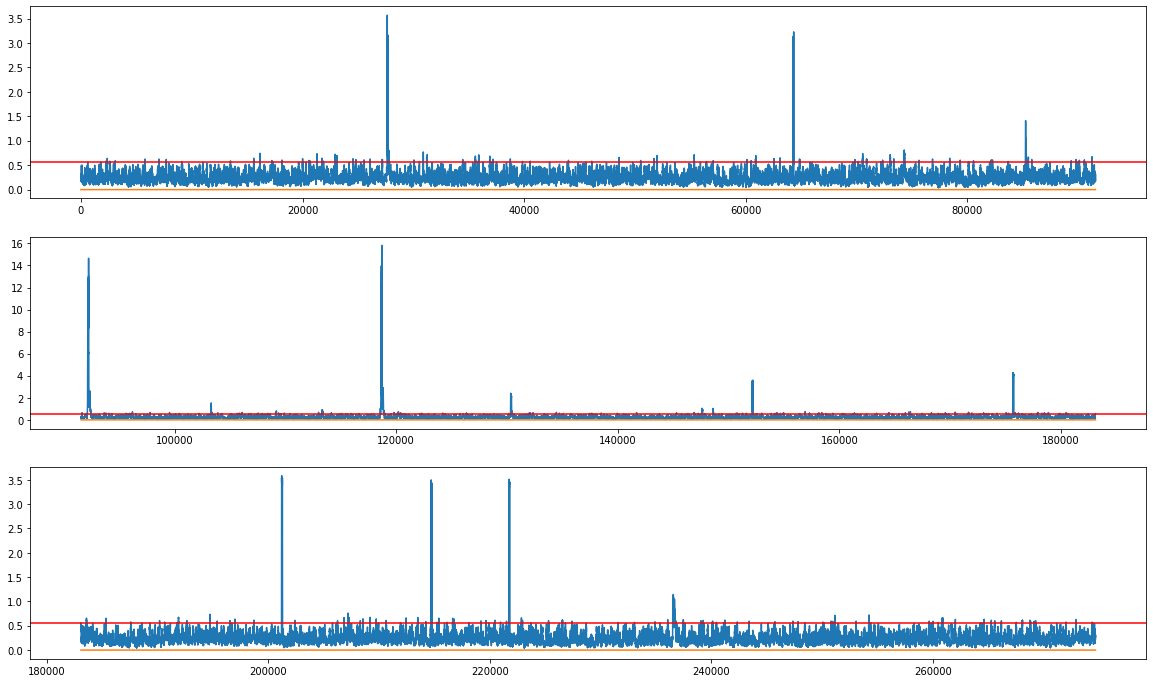

In [42]:
check_graph(ANOMALY_SCORE, CHECK_ATT, piece=3, THRESHOLD=THRESHOLD)

In [43]:
LABELS = put_labels(ANOMALY_SCORE, THRESHOLD)
LABELS, LABELS.shape

(array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), (274653,))

In [44]:
submission = pd.read_csv('dataset/sample_submission.csv')
submission.index = submission['timestamp']
submission.loc[CHECK_TS,'attack'] = LABELS
submission

,timestamp,attack
timestamp,,
2021-07-13 16:00:01,2021-07-13 16:00:01,0.0
2021-07-13 16:00:02,2021-07-13 16:00:02,0.0
2021-07-13 16:00:03,2021-07-13 16:00:03,0.0
2021-07-13 16:00:04,2021-07-13 16:00:04,0.0
2021-07-13 16:00:05,2021-07-13 16:00:05,0.0
...,...,...
2021-07-16 23:59:56,2021-07-16 23:59:56,0.0
2021-07-16 23:59:57,2021-07-16 23:59:57,0.0
2021-07-16 23:59:58,2021-07-16 23:59:58,0.0


In [45]:
submission.to_csv('제출용.csv', index=False)